## CNN_LSTM Base
- to capture spatial (CNN) -temporal (LSTM) information
- often used in NEXT FRAME VIDEO PREDICTION problem in vision

### Colab Link
- Run it with GPU: https://colab.research.google.com/drive/1mNi_gSTWDSto7EWnyh4ZVuQA3VfN56Hm#scrollTo=zVGtIJiqnJLB


### Sources

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9063513

https://keras.io/examples/vision/conv_lstm/

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-12-10 13:28:30.832484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [18]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"

sys.path.insert(0, '../src/preprocess')

from data_preprocess import preprocess_images_nfp

data,pco2 = preprocess_images_nfp(dir_name)


In [44]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

# gives you gradient exploding problem
# X=data[X_index][:-1]
y=np.expand_dims(pco2[X_index][1:],axis=4)
X=data[X_index][:-1]
#y=data[X_index][1:][:,:,:,:,5]
print(X.shape, y.shape)

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


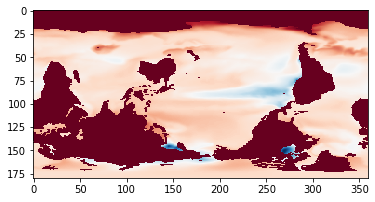

In [42]:
plt.imshow(y[0][0],cmap="RdBu", interpolation="nearest")

In [45]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=y[0].shape

INPUT_SHAPE

(3, 180, 360, 6)

In [46]:
tf.keras.backend.clear_session()

In [47]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

In [51]:
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial

DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(1,1)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(),
)

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8320      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 180, 360, 1)    865       
Total params: 205,025
Trainable params: 204,897
Non-trainable params: 128
______________________________________________

In [53]:
model_path="../models/base_CNN_LSTM.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 20
batch_size = 8

# Fit the model to the training data.
model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y),
    callbacks=callbacks,
)

Epoch 1/20
53/53 [==============================] - 53s 879ms/step - loss: 76.1091 - val_loss: 33.6065
Epoch 2/20
53/53 [==============================] - 44s 834ms/step - loss: 14.9899 - val_loss: 31.9371
Epoch 3/20
53/53 [==============================] - 44s 835ms/step - loss: 8.4707 - val_loss: 25.5391
Epoch 4/20
53/53 [==============================] - 44s 836ms/step - loss: 6.5495 - val_loss: 26.8671
Epoch 5/20
53/53 [==============================] - 44s 835ms/step - loss: 6.1680 - val_loss: 11.5188
Epoch 6/20
53/53 [==============================] - 44s 837ms/step - loss: 5.6518 - val_loss: 11.7564
Epoch 7/20
53/53 [==============================] - 44s 835ms/step - loss: 4.8510 - val_loss: 10.6706
Epoch 8/20
53/53 [==============================] - 44s 835ms/step - loss: 4.4353 - val_loss: 7.5105
Epoch 9/20
53/53 [==============================] - 44s 835ms/step - loss: 4.2120 - val_loss: 7.5452
Epoch 10/20
53/53 [==============================] - 44s 836ms/step - loss: 4.0225

In [54]:

best_model = tf.keras.models.load_model('../models/base_CNN_LSTM.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_frames=best_model.predict(X,verbose=1)

14/14 [==============================] - 21s 715ms/step


In [58]:
predicted_frames[y==0]=0.0

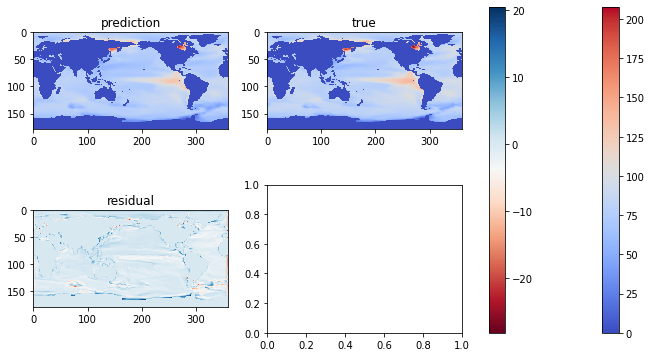

In [87]:
figure, axis = plt.subplots(2, 2,figsize=(12, 6))


img=axis[0][0].imshow(np.flipud(predicted_frames[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0][0]-y[0][0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest")
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)

plt.show()




In [88]:
# RMSE of pco2
np.sqrt(np.mean((predicted_frames-y)**2))

2.9300797449898

## Getting PCO2 Prediction per Point

In [119]:
def inverse_scale_image(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    output = arr*(old_max-old_min)/255+old_min
    return output

In [120]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2 = read_xarray(dir_name)
actual=inverse_scale_image(predicted_frames,pco2.pCO2.data)  

In [121]:
tmp=np.nan_to_num(pco2.pCO2.data[X_index][1:])
actual_y=np.expand_dims(tmp,axis=4)
actual_y.shape

(418, 3, 180, 360, 1)

In [122]:
actual[actual_y==0]=0

In [123]:
print("Scaled back RMSE score:")
np.sqrt(np.mean((actual_y-actual)**2))

Scaled back RMSE score:


8.246732488404765